In [1]:
from imbalance.pipeline import Pipeline
from imbalance.viz import metric_balance, data_distribution, plot_different_cvs, plot_different_n
from imbalance.data import eegbci, gaussian_binary
import matplotlib.pyplot as plt
from camcan.dataloaders import create_datasets
from scipy.stats import ttest_ind
import string
from copy import deepcopy
import pickle
import numpy as np
from torch.utils.data import ConcatDataset, DataLoader
import mne
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('seaborn')

def load_info():
    data_path = mne.datasets.sample.data_path()
    raw = mne.io.read_raw_fif(
        f"{data_path}/MEG/sample/sample_audvis_raw.fif", preload=False
    )
    return raw.pick_types(meg="mag").info


def generate_topomap(
    data,
    elec=None,
    ax= None,
    vmin=None,
    vmax=None,
    res=128,
    cmap="viridis",
    colorbar=True,
    tight_layout=True,
    mask=None,
    mask_params=None,
):    
    if elec is not None:
        mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=10)
        mask = np.zeros(102).astype(bool)
        mask[elec] = True
    
    if ax is None:
        fig, ax = plt.subplots()
    
    im, _ = plot_topomap(
        data,
        load_info(),
        res=128,
        cmap=cmap,
        vmax=data.max() if vmax is None else vmax,
        vmin=data.min() if vmin is None else vmin,
        show=False,
        show_names=False,
        contours=1,
        extrapolate="local",
        mask=mask,
        mask_params=mask_params,
    )
    
    divider = make_axes_locatable(ax)
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=ax_colorbar)

In [2]:
band_name = "gamma1"

train_size = 0.8    
seed = 42    
dattype = "passive"    
eventclf = True    
epoched = True    
band = 4

data_path = '/home/arthur/data/camcan/'
n_sub = 20

datasets = create_datasets(    
    data_path,    
    train_size,    
    max_subj=n_sub,    
    seed=seed,    
    dattype=dattype,    
    eventclf=eventclf,    
    epoched=epoched,    
    psd=True,                                                                                                                                                                                                  
)                                                                                                                                                                                                              
dataset = ConcatDataset(datasets)                                                                                                                                                                              
dataloader = DataLoader(dataset, batch_size=len(dataset))                                                                                                                                                      
x, y, groups = next(iter(dataloader))                                                                                                                                                                          
x = x[:, [1, 2]].mean(axis=1)  # averages the psd values for both gradiometers                                                                                                                                 
x = x.numpy()                                                                                                                                                                                                  
if band is not None:                                                                                                                                                                                           
    x = x[..., band]                                                                                                                                                                                           
    x = x[..., np.newaxis]            

averaged_x, averaged_y = [], []
for g in np.unique(groups):
    group_idx = np.where(groups == g)[0]
    y_group = y[group_idx]
    class0_idx = np.where(y_group == 0)[0]
    class1_idx = np.where(y_group == 1)[0]
    averaged_x.append((list(x[group_idx][class0_idx].mean(axis=0)), list(x[group_idx][class1_idx].mean(axis=0))))
    averaged_y.append(([0]*102, [1]*102))

averaged_y = np.array(averaged_y)
averaged_x = np.array(averaged_x)

tval, _ = ttest_ind(averaged_x[:,0,:,0], averaged_x[:,1,:,0])
np.save("gamma1_tvalues.npy", tval)

Opening raw data file /home/arthur/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


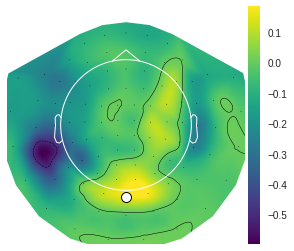

In [3]:
tval = np.load("gamma1_tvalues.npy")
generate_topomap(tval, elec=78)